Humpback Whale Classification
==================

[Everyday I am Kaggling](https://www.kaggle.com/c/whale-categorization-playground)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

## Reading dataset

In [2]:
train_data = pd.read_csv('train.csv', sep=',',header=0)
training_values = train_data['Image'].values
training_labels = train_data.drop('Image', 1).values

print("The whale dataset is a folder named `train` with whale images names.")
print("The whale dataset contains a `train.csv` which maps image name with Id\n")
print(training_labels[:10].flatten())
print("\nThere are some whales which are not identifed and thus labelled `new_whale`")

The whale dataset is a folder named `train` with whale images names.
The whale dataset contains a `train.csv` which maps image name with Id

['w_e15442c' 'w_1287fbc' 'w_da2efe0' 'w_19e5482' 'w_f22f3e3' 'w_8b1ca89'
 'w_eaad6a8' 'new_whale' 'w_3d0bc7a' 'w_50db782']

There are some whales which are not identifed and thus labelled `new_whale`


## Preview the images

<IPython.core.display.Javascript object>


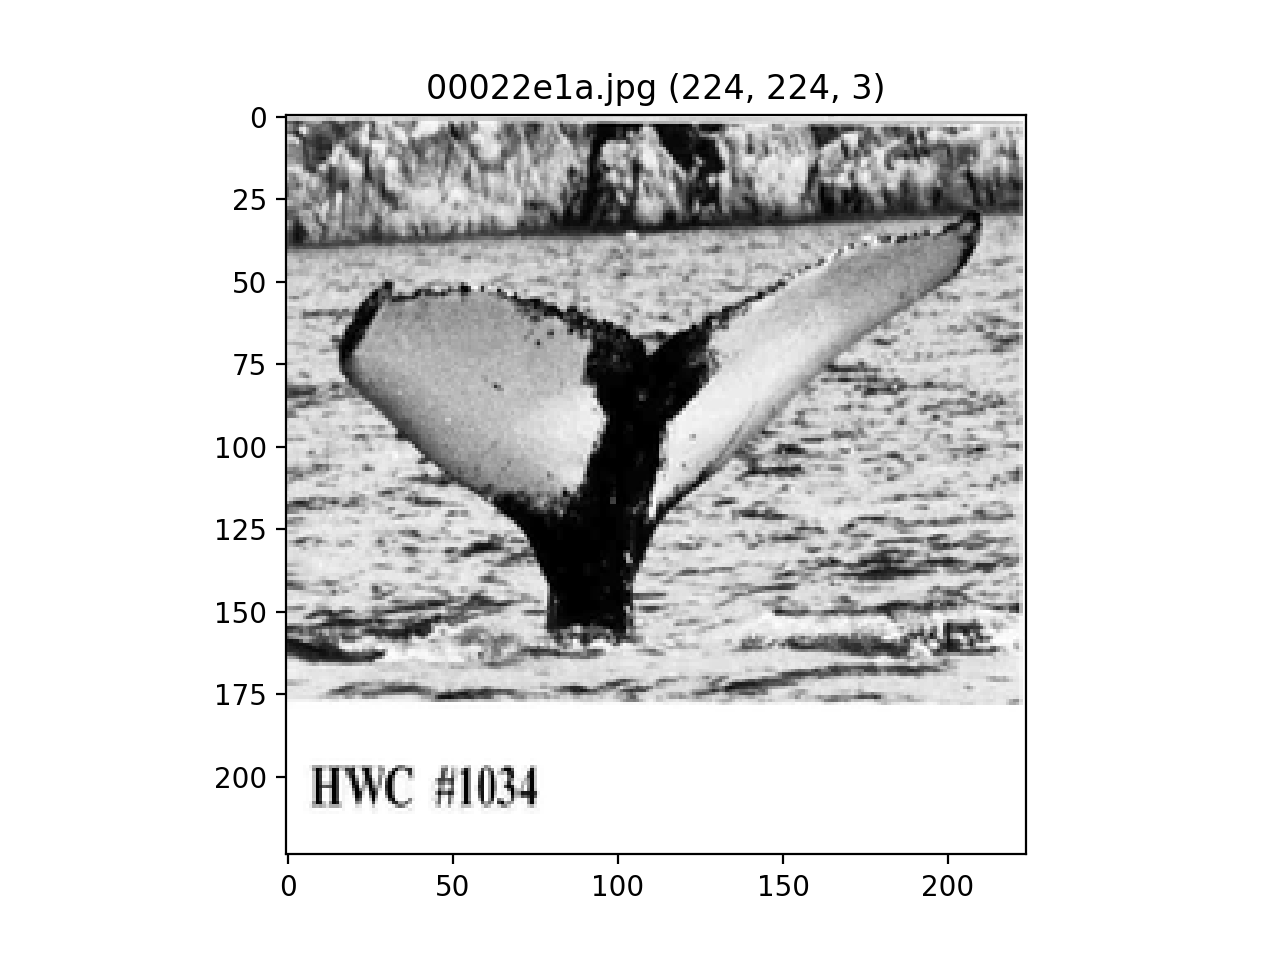

<IPython.core.display.Javascript object>


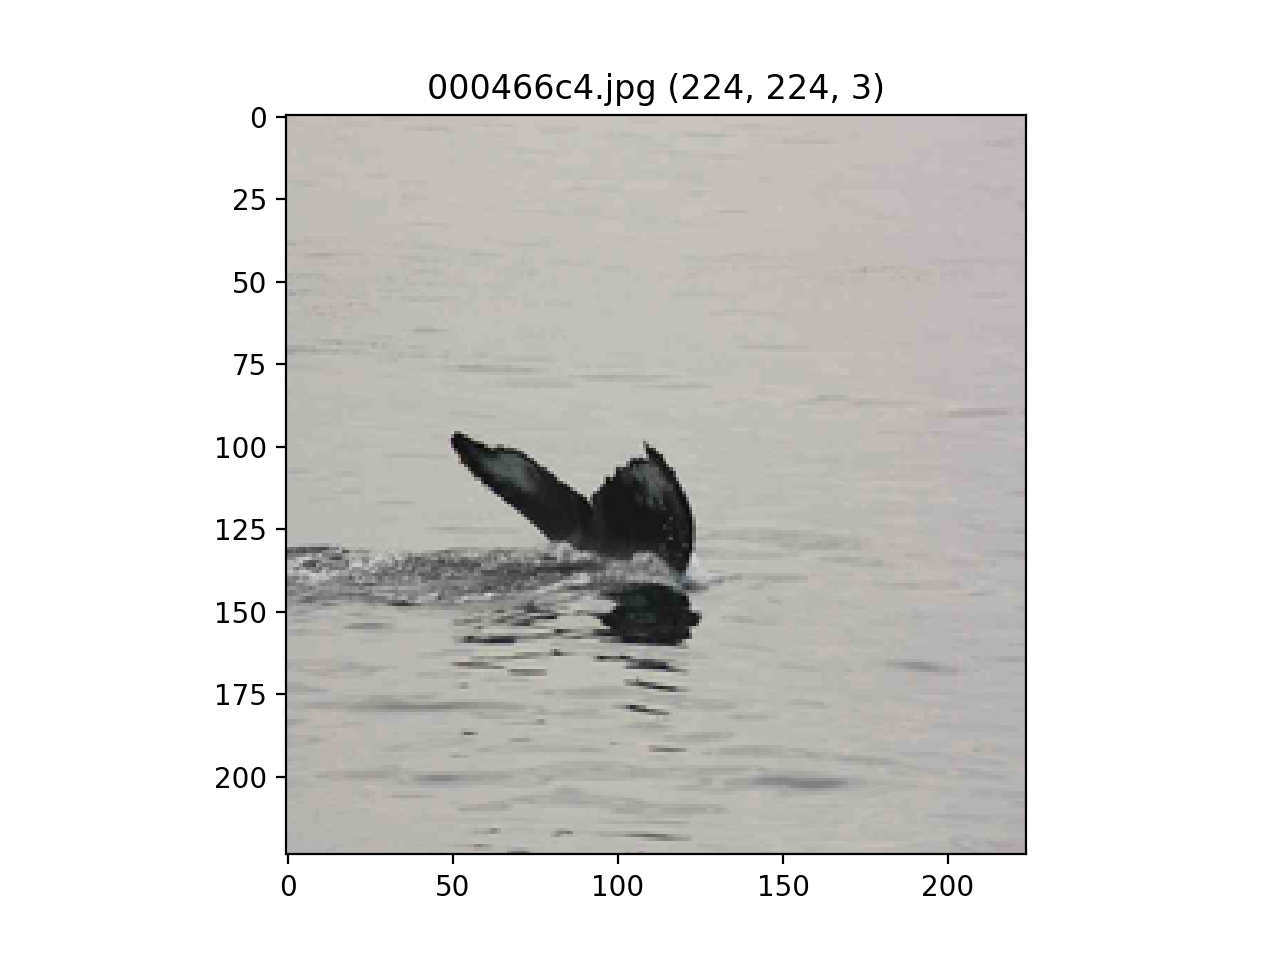

<IPython.core.display.Javascript object>


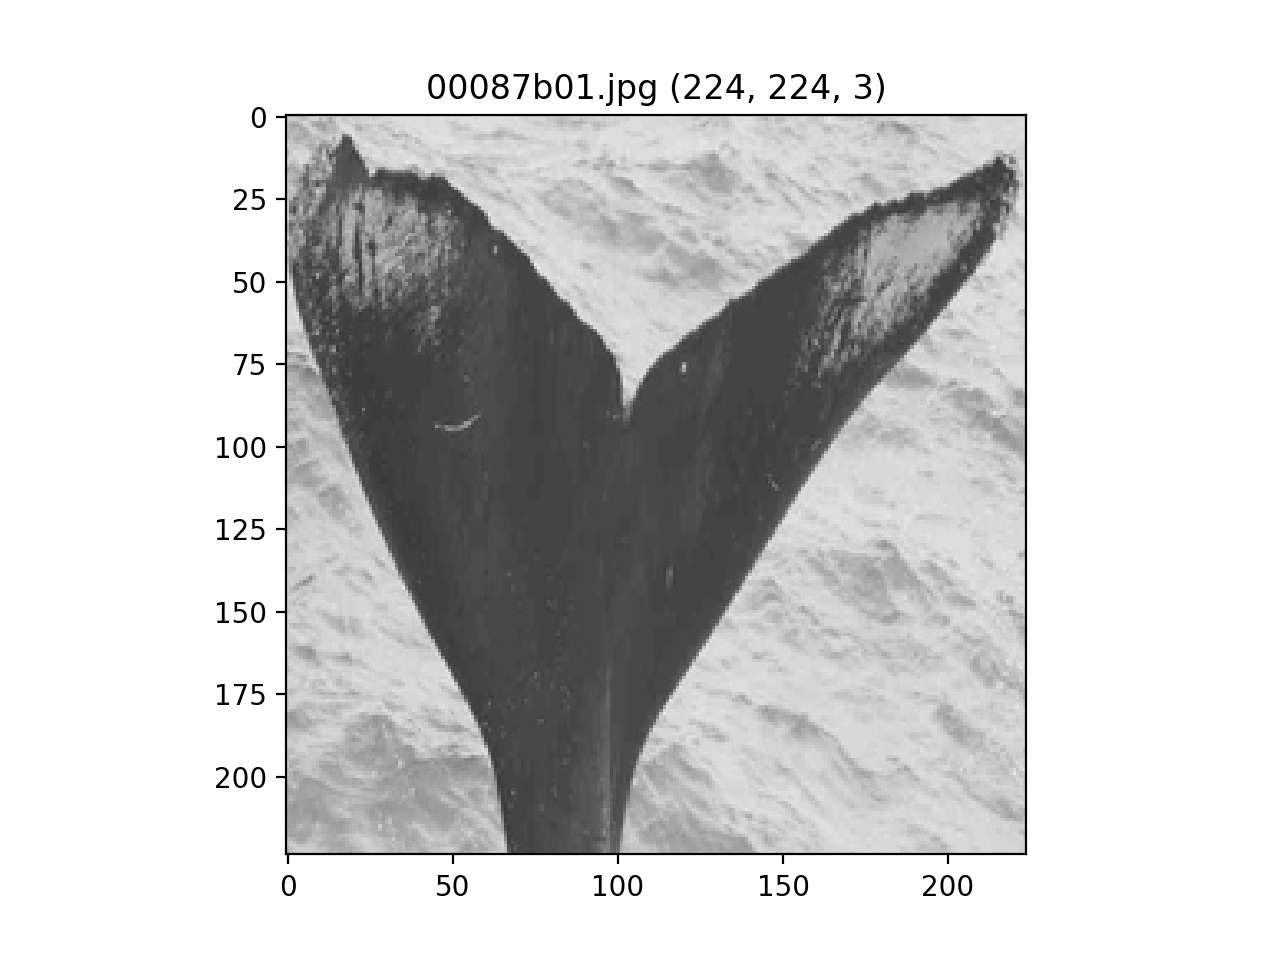

In [48]:
from PIL import Image
from matplotlib.pyplot import imshow

def read_image(filename, for_preview=False):
    # read the image and return a bitmap
    pil_im = Image.open("train/{}".format(filename), 'r')
    
    raw_mode = pil_im.mode
    if pil_im.mode == "L":
        pil_im = pil_im.convert('RGB')
    pil_im = pil_im.resize((224, 224),  Image.ANTIALIAS)
    image = np.asarray(pil_im)
    return image/255 if for_preview is False else image

def preview_image(filename):
    image = read_image(filename, True)
    _, axes = plt.subplots()
    
    plt.title("{} {}".format(filename, image.shape))
    axes.imshow(image, interpolation='nearest')

for image in training_values[:3]:
    preview_image(image)

## Analyzing the data

We have to find out frequency distribution of each whale tail classification. If some whale classification are underpresented, we have augment our dataset to make sure there is enough data for our model to learn from

In [49]:
new_df = pd.value_counts(train_data.Id).sort_index()
new_df.columns = ['Id', 'frequency']
new_df.head(30)

new_whale    810
w_0013924      3
w_001ebbc      1
w_002222a      2
w_002b682      1
w_002dc11      1
w_0087fdd      2
w_008c602      1
w_009dc00      2
w_00b621b      2
w_00c4901      1
w_00cb685      3
w_00d8453      1
w_00fbb4e      2
w_0103030      1
w_010a1fa      2
w_011d4b5      2
w_0122d85      1
w_01319fa      1
w_0134192      1
w_013bbcf      1
w_014250a      2
w_014a645      1
w_0156f27      1
w_015c991      1
w_015e3cf      1
w_01687a8      2
w_0175a35      1
w_018bc64      1
w_01a4234      1
Name: Id, dtype: int64

## One hot encoding

The labels, `w_0265cb6`, `w_029013f` are string values and need to be one-hot encoded so that our network can train on them.

`LabelEncoder` + `OneHotEncoder` = `LabelBinarizer`

In [50]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(training_labels.flatten())
print(labels)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


## Use resnet50 network

We would be using [pretrained ResNet50 network originally created by researchers at Microsoft](Deep Residual Learning for Image Recognition). Keras provides a pre-trained model built on top of the Paper

In [51]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import SGD, Adamax
from keras.losses import categorical_crossentropy
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint, Callback
from keras.utils import Sequence

output_size = len(label_binarizer.classes_)

resenet50_model = ResNet50(include_top=False, input_shape=(224, 224, 3))
for layer in resenet50_model.layers[:6]:
    layer.trainable = False

model = Sequential()
model.add(resenet50_model)
model.add(Flatten())
model.add(Dense(output_size, activation="softmax"))
model.compile(loss=categorical_crossentropy,
              optimizer=Adamax(lr=0.02),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 4251)              8710299   
Total params: 32,298,011
Trainable params: 32,231,131
Non-trainable params: 66,880
_________________________________________________________________


In [52]:
from sklearn.model_selection import train_test_split

print(training_values.shape, labels.shape)
X_train, X_val, Y_train, Y_val = train_test_split(training_values, labels, test_size=0.2, random_state=2)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

class WhaleGenerator(Sequence):
    def __init__(self, X, Y, title, batch_size=32):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.title = title
        
    def __len__(self):
        return int(np.floor(len(self.X) / self.batch_size))

    def __iter__(self):
        return self
    
    def __getitem__(self, index):
        start =index*self.batch_size
        end = (index+1)*self.batch_size
        
        batch_x, batch_y = np.array([read_image(x) for x in self.X[start : end]]), self.Y[start : end]
        return batch_x, batch_y


checkpoint = ModelCheckpoint("./best.hdf5", monitor='val_acc', save_best_only=True,  mode='max')
history = LossHistory()


model.fit_generator(WhaleGenerator(X_train, Y_train, "Train"), epochs=3, \
        validation_data=WhaleGenerator(X_val, Y_val, "Val"), callbacks=[checkpoint, history])

(9850,) (9850, 4251)
(7880,) (1970,) (7880, 4251) (1970, 4251)
Epoch 1/3
246/246 [==============================] - 305s 1s/step - loss: 8.4931 - acc: 0.0831 - val_loss: 14.8878 - val_acc: 0.0763
Epoch 2/3
246/246 [==============================] - 285s 1s/step - loss: 8.0223 - acc: 0.0838 - val_loss: 8.5709 - val_acc: 0.0763
Epoch 3/3
246/246 [==============================] - 285s 1s/step - loss: 7.9199 - acc: 0.0837 - val_loss: 8.6364 - val_acc: 0.0763


<IPython.core.display.Javascript object>


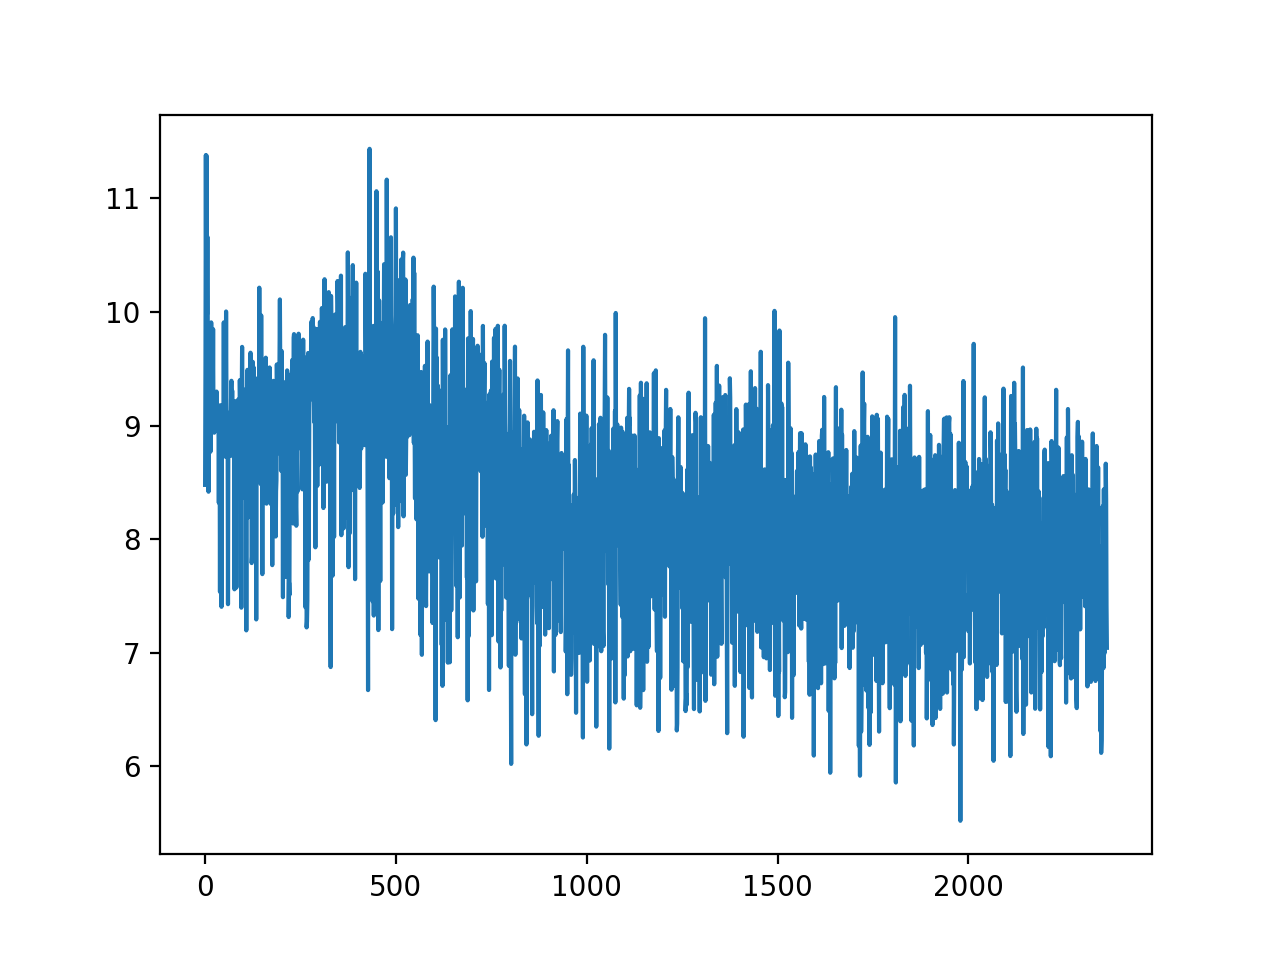

In [31]:
%matplotlib notebook
plt.plot(losses)